# Sequence to Sequence models for sugar level prediction

Seq2Seq modelling with Recurrent Neural Networks, 
take a look at https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

We also try teacher-forcing training, but it does not seem to provide good results in inference. 

Finally, we use ConvNets for creating input features to the encoder.

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import os
import sys
import time
import copy
import tensorflow as tf

In [0]:
from tensorflow.keras.layers import Dense, LSTM, Input, RepeatVector, concatenate
from tensorflow.keras.layers import Embedding, GaussianNoise, Reshape, Dropout 
from tensorflow.keras.layers import Convolution1D, AveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MAE
from tensorflow.keras.metrics import MAPE, MSE
from tensorflow.keras.backend import clear_session
from tensorflow.keras.constraints import max_norm

## Data preprocessing

### Load datasets

Each dataset consits of sequences of `history`+`future` points, with 4 features: 

* time interval: days counted starting from the end of the `history` of the sequence. Thus, for points in the `history`, this feature takes negatuve values, while for points in the `future`, it's positive. 
* hour: hour of the day, divided by 24.
* day of week: day of the week in numbers ('Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6), divided by 7.
* sugar level: recorded sugar level, scaled with min/max scaler.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
root = "/content/drive/My Drive/Colab Notebooks/sugar_level_prediction/data/processed/normalized"
lastdate = '2020-01-16'
root = os.path.join(root, lastdate)

history = 3 * 24 * 4
future = 3 * 4

noise = 0.0
replace = False

train = np.load(os.path.join(root, "noise_%s_train_steps_%s_replace_%s.npy" %(noise, int(history), replace)))
vad = np.load(os.path.join(root, "noise_%s_vad_steps_%s_replace_%s.npy" %(noise, int(history), replace)))
test = np.load(os.path.join(root, "noise_%s_test_steps_%s_replace_%s.npy" %(noise, int(history), replace)))

assert history+future == train.shape[1]

In [0]:
np.random.seed(1203)
np.random.shuffle(train)

###  Split data 

Each input sequence has both the features and labels (x and y, if you wish), so we have to separate them.

In [0]:
def split_features_labels(data, history, future, start_char):
    """
    Method to separate historic and future events (features and labels). 
    It returns input data for the encoder and decoder, and the output data 
    for the decoder. The input data for the decoder is just the output data 
    of the decoder, shifted by one step. 

    :param data: numpy ndarray with sequences of history+future points, and 4 attributes 
      (time_interval, hour_of_day, day_of_week, patient_id, sugar_level). It has shape (?, history+future, 5)
    :param history: number of points for the features
    :param future: number of points for the labels
    :param start_char: start charcter for input sequences to the decoder
    :return three numpy arrays with the input data for the encoder (shape=(?, history, 5))
        and decoder (shape=(?, future+1, 1)), and the output data for the decoder
        (shape=(?, future+1, 1))
    """
    # split features and labels . Note that for the later, we only keep the 
    # feature with the sugar level, which constitutes our target
    yf, yl = data[:, :history], data[:, history:history+future, -1]
    
    # add start of sentence to labels (input to the decoder)
    yl_input = start_char * np.ones(shape=(yl.shape[0], yl.shape[1]+1))
    yl_input[:, 1:] = yl
    # add end of sentence to labels (output of the decoder)
    yl_output = start_char * np.ones(shape=(yl.shape[0], yl.shape[1]+1))
    yl_output[:, :-1] = yl
    
    # add new dimension at the end of input/output arrays to the decoder
    yl_input = yl_input[:, :, np.newaxis].astype(np.float32)
    yl_output = yl_output[:, :, np.newaxis].astype(np.float32)
    
    return (yf, yl_input), yl_output

In [0]:
start_char = -1.0
train_data = split_features_labels(train, history, future, start_char)
vad_data = split_features_labels(vad, history, future, start_char)
test_data = split_features_labels(test, history, future, start_char)

In [11]:
train_data[0][0].shape, train_data[0][1].shape, train_data[1].shape

((144942, 288, 5), (144942, 13, 1), (144942, 13, 1))

## Some auxiliar functions 



In [0]:
def plot_train_history(history, title, metric):
    plt.figure(figsize=(12, 6))
    loss = history[metric]
    val_loss = history['val_%s' %metric]

    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', label='Training %s' %metric)
    plt.plot(epochs, val_loss, 'r', label='Validation %s' %metric)
    plt.title(title)
    plt.legend()
    
    plt.yscale('log')
    plt.gca().grid(axis='y', which='minor')

    plt.show()

def plot_results(dataset, prediction, history, future):
    plt.figure(figsize=(12, 6))

    # get random idx
    idx = np.random.randint(0, dataset.shape[0])

    # get intervals
    xf = dataset[idx, :history, 0]
    xl = dataset[idx, history:history+future, 0]
    
    # get sequences
    input_seq_ = dataset[idx, :history, -1]
    target_seq_ = dataset[idx, history:history+future, -1]
    decoded_seq_ = prediction[idx, :]

    ymin = input_seq_.min()-30
    ymax = input_seq_.max()+30
    
    plt.plot(xf, input_seq_, '-b', markersize=2, linewidth=2, label='historic data')
    plt.plot(xl, target_seq_, '.--b', markersize=2, linewidth=2, label='future data')
    plt.plot(xl, decoded_seq_, '.--k', markersize=2, linewidth=2, label='prediction')
    plt.vlines(x=0, ymin=ymin, ymax=ymax, colors='k', linewidth=1, linestyles='--')

    plt.ylim(ymin, ymax)
    plt.xlim(-0.3-history/4/24, future/4/24+0.3)
    
    plt.ylabel('Glucose evolution (arb.units)')
    plt.xlabel('Days before/after start prediction')
    plt.legend(loc='best')

    plt.show()

In [0]:
def mae(dataset, prediction, history, future):
    expected = dataset[:, history:history+future, -1]
    return np.mean(np.abs(expected - prediction))

def plot_metric(arr):
    x = arr[:, 0]
    y = arr[:, 1]
    z = arr[:, 2]
    
    plt.figure()
    plt.title('MAE error')
    plt.plot(x, y,  '.--k', markersize=5, linewidth=2, label='train')
    plt.plot(x, z,  '.--b', markersize=5, linewidth=2, label='val')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Average Error')
    plt.legend(loc='best')
    plt.show()

## Seq2Seq model 

### Model

#### Class ProcessInput 

In [0]:
class ProcessInput(tf.keras.Model):
  def __init__(self, dense_dim, dense_activation, gaussian_noise, num_ids,
               day_of_week_dim, hour_of_day_dim, patient_id_dim,
               **kwargs):
    super(ProcessInput, self).__init__(**kwargs)

    # define attribute variables
    self.dense_dim = dense_dim
    self.dense_activation = dense_activation
    self.gaussian_noise = gaussian_noise
    self.num_ids = num_ids
    self.day_of_week_dim = day_of_week_dim 
    self.hour_of_day_dim = hour_of_day_dim 
    self.patient_id_dim = patient_id_dim

    # Define embedding layers for Input categorical layers
    self.day_of_week_emb = Embedding(input_dim=7, output_dim=self.day_of_week_dim)
    self.hour_of_day_emb = Embedding(input_dim=24, output_dim=self.hour_of_day_dim)
    self.patient_id_emb = Embedding(input_dim=self.num_ids, output_dim=self.patient_id_dim)

    # gaussian noise layer 
    if self.gaussian_noise: 
      self.gn_layer = GaussianNoise(stddev=self.gaussian_noise)
    else: 
      self.gn_layer = None
    # dense layer
    if self.dense_dim: 
      # TODO use TimeDistributed before the Dense? I believe the layer is broadcasted here
      self.dense = Dense(self.dense_dim, activation=self.dense_activation)
    else:
        self.dense = None

  def call(self, inputs, training=False):
    # split inputs
    time_interval, hour_of_day, day_of_week, patient_id, sugar_level = inputs
    # create embeddings for categorical variables
    day_of_week = self.day_of_week_emb(day_of_week)
    hour_of_day = self.hour_of_day_emb(hour_of_day)
    patient_id = self.patient_id_emb(patient_id)

    # add noise
    if self.gn_layer:
        sugar_level = self.gn_layer(sugar_level, training=training)
    
    # Concatenate all inputs toghether, and pass them through a dense layer
    output = concatenate([time_interval, hour_of_day, day_of_week, 
                          patient_id, sugar_level], axis=-1)
    if self.dense:
        output = self.dense(output)
    return output

In [0]:
# simple testing
test_layer = ProcessInput(dense_dim=None, dense_activation=None, gaussian_noise=0.1, 
                          num_ids=7, day_of_week_dim=10, hour_of_day_dim=10, 
                          patient_id_dim=10)

assert test_layer.dense == None
assert test_layer.gaussian_noise == 0.1
assert test_layer.gn_layer.stddev == 0.1

out = test_layer([Input(shape=(None, 1)), Input(shape=(None,)), Input(shape=(None,)), 
                  Input(shape=(None,)), Input(shape=(None, 1))])
assert out.get_shape().as_list() == [None, None, 32]

out = test_layer([Input(shape=(16, 1)), Input(shape=(16,)), Input(shape=(16,)), 
                  Input(shape=(16,)), Input(shape=(16, 1))])
assert out.get_shape().as_list() == [None, 16, 32]

#### Class Encoder


In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, stacked_units, kernel_mn, recurrent_mn, dropout, **kwargs):
    super(Encoder, self).__init__(**kwargs)
    self.stacked_units = stacked_units
    self.kernel_mn = kernel_mn
    self.recurrent_mn = recurrent_mn
    self.dropout = dropout

    # for loop to stack lstms, with returning sequences
    self.lstms = self.stack_lstms()

  def call(self, inputs, training=False):
    for lstm in self.lstms[:-1]:
      inputs = lstm(inputs, training=training)
    encoder_outputs, state_h, state_c = self.lstms[-1](inputs ,training=training)
    encoder_states = [state_h, state_c]  
    return encoder_outputs, encoder_states

  def stack_lstms(self):
    # for loop to stack lstms, with returning sequences
    lstms = []
    for units in self.stacked_units[:-1]:
      lstm_ = LSTM(
        units, 
        return_sequences=True, 
        kernel_constraint=max_norm(self.kernel_mn),
        recurrent_constraint=max_norm(self.recurrent_mn), 
        dropout=self.dropout)
      lstms.append(lstm_)

    # the last lstm returns the states as well as the sequences
    lstm_ = LSTM(
      self.stacked_units[-1], 
      return_state=True, 
      return_sequences=True, 
      kernel_constraint=max_norm(self.kernel_mn),
      recurrent_constraint=max_norm(self.recurrent_mn), 
      dropout=self.dropout)
    lstms.append(lstm_)
    return lstms

In [0]:
# simple testing
input_test_layer = ProcessInput(
  dense_dim=None, dense_activation=None, gaussian_noise=0.0, num_ids=7, 
  day_of_week_dim=10, hour_of_day_dim=10, patient_id_dim=10)

input_test_layer = input_test_layer(
  [Input(shape=(16, 1)), Input(shape=(16,)), Input(shape=(16,)), 
   Input(shape=(16,)), Input(shape=(16, 1))])

test_enc = Encoder(stacked_units=[5, 5], kernel_mn=0.3, recurrent_mn=0.1, dropout=0.3)
enc_lstms = test_enc.lstms
assert len(enc_lstms) == 2

encoder_outputs, encoder_states = test_enc(input_test_layer)
assert len(encoder_states) == 2
assert encoder_outputs.get_shape().as_list() == [None, 16, 5]

#### Attention Layer

In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units, kernel_mn):
    super(BahdanauAttention, self).__init__()
    self.units = units
    self.kernel_mn = kernel_mn
    
    # Weights relating to target states (decoder typically)
    self.source_weight = tf.keras.layers.Dense(units, kernel_constraint=max_norm(kernel_mn))  
    # Weights relating to source states (encoder typically)
    self.target_weight = tf.keras.layers.Dense(units, kernel_constraint=max_norm(kernel_mn))  
    # score transformation
    self.score_weight = tf.keras.layers.Dense(1)  

  def call(self, inputs, training=False):
    # target is also referred as query, and source as values.
    target, source = inputs
    # target must be a hidden vector of shape=(None, hidden_size), 
    # while source has shape=(None, steps, hidden_size)

    # expand the dimension of the target, (None, 1, hidden_size)
    target_with_time_axis = tf.expand_dims(target, axis=1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.score_weight(
        tf.nn.tanh(
            self.source_weight(source) + self.target_weight(target_with_time_axis)
            )
        )

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * source
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
# simple testing
input_test_layer = ProcessInput(
  dense_dim=None, dense_activation=None, gaussian_noise=0.0, num_ids=7, 
  day_of_week_dim=10, hour_of_day_dim=10, patient_id_dim=10)

input_test_layer = input_test_layer(
  [Input(shape=(16, 1)), Input(shape=(16,)), Input(shape=(16,)), 
   Input(shape=(16,)), Input(shape=(16, 1))])

test_enc = Encoder(stacked_units=[5, 5], kernel_mn=0.3, recurrent_mn=0.1, dropout=0.3)
encoder_outputs, encoder_states = test_enc(input_test_layer)
encoder_hidden = encoder_states[0]

attention_layer = BahdanauAttention(10, kernel_mn=0.2)
attention_result, attention_weights = attention_layer([encoder_hidden, encoder_outputs])

assert attention_layer.source_weight.get_input_shape_at(0) == (None, 16, 5)
assert attention_layer.source_weight.get_output_shape_at(0) == (None, 16, 10)

# why this does not work?
# attention_layer.score_weight.get_output_shape_at(0)

assert attention_result.get_shape()[1] == 5
assert attention_weights.get_shape().as_list() == [None, 16, 1]

#### Class decoder


In [0]:
class Decoder(Encoder):
  def __init__(self, stacked_units, kernel_mn, recurrent_mn, dropout, 
               mlp_units, activation_mlp, mlp_mn, attention_kernel_mn,
               **kwargs):
    super(Decoder, self).__init__(stacked_units, kernel_mn, recurrent_mn, dropout, **kwargs)
    self.mlp_units = mlp_units 
    self.activation_mlp = activation_mlp
    self.mlp_mn = mlp_mn
    self.attention_kernel_mn = attention_kernel_mn

    self.mlp = self.mlp()
    self.attention = BahdanauAttention(units=self.stacked_units[-1], 
                                       kernel_mn=attention_kernel_mn)

  def call(self, inputs, training=False):
    # split inputs in teacher forcing input (can be None), target state (decoder at t-1)
    # and source states (outputs from the encoder)
    teacher_input, target, source_seq = inputs
    context_vector, attention_weights = self.attention(inputs=[target, source_seq], 
                                                       training=training)
    
    # concatenate context vector and tf_input
    context_vector = tf.expand_dims(context_vector, 1)  # shape=(None, 1, dec_hidden_size)
    if teacher_input is not None:
      merged = tf.concat([context_vector, teacher_input], axis=-1)
    else:
      merged = context_vector
    
    # pass the merged vector through the stack of LSTMs
    for lstm in self.lstms[:-1]:
      merged = lstm(merged, training=training)
    decoder_outputs, state_h, state_c = self.lstms[-1](merged, training=training)
    decoder_states = [state_h, state_c]  
    
    # reshape output, as we pass one step at a time
    decoder_outputs = tf.reshape(decoder_outputs, (-1, decoder_outputs.shape[2]))
    
    # pass the output to the mlp. output shape=(None, 1)
    out = decoder_outputs
    for dense in self.mlp:
      out = dense(out)
    return out, decoder_states, attention_weights

  def mlp(self):
    # MLP for output sequences
    mlp_stack = []
    for neurons in self.mlp_units:
        decoder_dense = Dense(neurons, activation=self.activation_mlp, 
                              kernel_constraint=max_norm(self.mlp_mn))
        mlp_stack.append(decoder_dense)
    return mlp_stack

In [0]:
# simple testing
input_test_layer = ProcessInput(
  dense_dim=None, dense_activation=None, gaussian_noise=0.0, num_ids=7, 
  day_of_week_dim=10, hour_of_day_dim=10, patient_id_dim=10)

input_test_layer = input_test_layer(
  [Input(shape=(16, 1)), Input(shape=(16,)), Input(shape=(16,)), 
   Input(shape=(16,)), Input(shape=(16, 1))])

test_enc = Encoder(stacked_units=[5, 5], kernel_mn=0.3, recurrent_mn=0.1, dropout=0.3)
encoder_outputs, encoder_states = test_enc(input_test_layer)
encoder_hidden = encoder_states[0]

# test with teacher-forcing
test_dec = Decoder(stacked_units=[5, 5], kernel_mn=0.3, recurrent_mn=0.1, 
                   dropout=0.3, mlp_units=[4, 1], activation_mlp='relu', 
                   mlp_mn=0.4, attention_kernel_mn=0.2)
input_teacher = Input(shape=(1, 1))

# initial step
input_dec = [input_teacher, encoder_hidden, encoder_outputs]
decoder_outputs, decoder_states, attention_weights = test_dec(input_dec)

assert len(decoder_states) == 2
assert decoder_states[0].get_shape().as_list() == [None, 5]
assert decoder_outputs.get_shape().as_list() == [None, 1]
assert attention_weights.get_shape().as_list() == [None, 16, 1]

# subsequent steps. 
decoder_hidden = decoder_states[0]
input_dec = [input_teacher, decoder_hidden, encoder_outputs]
decoder_outputs, decoder_states, attention_weights = test_dec(input_dec)

assert decoder_outputs.get_shape().as_list() == [None, 1]
assert attention_weights.get_shape().as_list() == [None, 16, 1]

# Finally test without teacher-forcing
test_dec = Decoder(stacked_units=[5, 5], kernel_mn=0.3, recurrent_mn=0.1, 
                   dropout=0.3, mlp_units=[4, 1], activation_mlp='relu', 
                   mlp_mn=0.4, attention_kernel_mn=0.2)
input_teacher = None

# initial step
input_dec = [input_teacher, encoder_hidden, encoder_outputs]
decoder_outputs, decoder_states, attention_weights = test_dec(input_dec)

assert len(decoder_states) == 2
assert decoder_states[0].get_shape().as_list() == [None, 5]
assert decoder_outputs.get_shape().as_list() == [None, 1]
assert attention_weights.get_shape().as_list() == [None, 16, 1]

# subsequent steps. 
decoder_hidden = decoder_states[0]
input_dec = [input_teacher, decoder_hidden, encoder_outputs]
decoder_outputs, decoder_states, attention_weights = test_dec(input_dec)
assert decoder_outputs.get_shape().as_list() == [None, 1]
assert attention_weights.get_shape().as_list() == [None, 16, 1]


#### Complete model


In [0]:
def get_columns(data):
    """
    Split and prepare input data

    :param data: array with four columns: time_interval, hour_of_day, 
        day_of_week, sugar_level
    """
    time_interval, hour_of_day, day_of_week, patient_id, sugar_level = np.split(data, 
        indices_or_sections=5, axis=2)
    # squeeze categorical features (ncessary for the Embedding layer)
    hour_of_day = np.squeeze(hour_of_day, axis=2)
    day_of_week = np.squeeze(day_of_week, axis=2)
    patient_id = np.squeeze(patient_id, axis=2)
    return (time_interval, hour_of_day, day_of_week, patient_id, sugar_level)

In [0]:
input_train = get_columns(train_data[0][0])
target_train = train_data[1]

input_vad = get_columns(vad_data[0][0])
target_vad = vad_data[1]

In [0]:
buffer_size = input_train[0].shape[0]
batch_size = 200
steps_per_epoch = buffer_size // batch_size

train_dataset = tf.data.Dataset.from_tensor_slices((input_train, target_train))
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

vad_dataset = tf.data.Dataset.from_tensor_slices((input_vad, target_vad))
vad_dataset = vad_dataset.batch(batch_size, drop_remainder=True)

In [25]:
num_identifiers = np.unique(input_train[3]).size
print("There are %s individuals" % num_identifiers)

There are 7 individuals


In [0]:
class Seq2SeqModel(tf.keras.Model):
  def __init__(self, dense_dim, dense_activation, gaussian_noise,
               num_ids, day_of_week_dim, hour_of_day_dim, patient_id_dim,
               enc_stacked_units, enc_kernel_mn, enc_recurrent_mn,
               enc_dropout, dec_stacked_units, dec_kernel_mn, dec_recurrent_mn, 
               dec_dropout, attention_kernel_mn, mlp_units, activation_mlp, 
               mlp_mn, teacher_forcing, start_char, learning_rate, clipvalue, 
               **kwargs):
    super(Seq2SeqModel, self).__init__(**kwargs)

    # clear worksapce
    tf.keras.backend.clear_session()

    # ProcessInput parameters
    self.dense_dim = dense_dim 
    self.dense_activation = dense_activation 
    self.gaussian_noise = gaussian_noise
    self.num_ids = num_ids 
    self.day_of_week_dim = day_of_week_dim 
    self.hour_of_day_dim = hour_of_day_dim 
    self.patient_id_dim = patient_id_dim

    # Encoder Parameters
    self.enc_stacked_units = enc_stacked_units 
    self.enc_kernel_mn = enc_kernel_mn 
    self.enc_recurrent_mn = enc_recurrent_mn
    self.enc_dropout = enc_dropout 

    # Decoder parameters
    self.dec_stacked_units = dec_stacked_units 
    self.dec_kernel_mn = dec_kernel_mn 
    self.dec_recurrent_mn = dec_recurrent_mn 
    self.dec_dropout = dec_dropout 
    self.mlp_units = mlp_units 
    self.activation_mlp = activation_mlp 
    self.mlp_mn = mlp_mn 
    self.attention_kernel_mn = attention_kernel_mn

    # Optimization parameters
    self.learning_rate = learning_rate 
    self.clipvalue = clipvalue

    # Others
    self.teacher_forcing = teacher_forcing
    self.start_char = start_char

    # build and compile
    self.build()
    self.compile()

  def build(self):
    self.process_layer = ProcessInput(
      dense_dim=self.dense_dim, dense_activation=self.dense_activation, 
      gaussian_noise=self.gaussian_noise, num_ids=self.num_ids, 
      day_of_week_dim=self.day_of_week_dim, hour_of_day_dim=self.hour_of_day_dim, 
      patient_id_dim=self.patient_id_dim)

    self.encoder = Encoder(
      stacked_units=self.enc_stacked_units, kernel_mn=self.enc_kernel_mn, 
      recurrent_mn=self.enc_recurrent_mn, dropout=self.enc_dropout)

    self.decoder = Decoder(
      stacked_units=self.enc_stacked_units, kernel_mn=self.enc_kernel_mn, 
      recurrent_mn=self.enc_recurrent_mn, dropout=self.enc_dropout, 
      mlp_units=self.mlp_units, activation_mlp=self.activation_mlp, 
      mlp_mn=self.mlp_mn, attention_kernel_mn=self.attention_kernel_mn)

  def compile(self):
    self.optimizer = tf.keras.optimizers.Adam(
      learning_rate=self.learning_rate, clipvalue=self.clipvalue)
    self.loss_function = tf.keras.losses.MeanSquaredError()
    self.metric_functions = [tf.keras.losses.MeanAbsoluteError()]

  @tf.function
  def train_step(self, inp, tar):
    loss = 0
    metric = 0
    
    with tf.GradientTape() as tape:
      input_enc = self.process_layer(inp, training=True)
      enc_outputs, enc_states = self.encoder(input_enc, training=True)
      dec_hidden = enc_states[0]
      
      # provide start_char as first input char
      dec_input = self.start_char * tf.ones_like(tar[:, 0, :])
      
      for t in range(0, tar.shape[1]-1):
        # expand dim of dec_input
        dec_input = tf.expand_dims(dec_input, axis=1)
        # passing enc_output to the decoder
        predictions, dec_states, _ = self.decoder(inputs=[dec_input, dec_hidden, enc_outputs], 
                                                  training=True)
        dec_hidden = dec_states[0]

        loss += self.loss_function(tar[:, t, :], predictions)
        metric = self.metric_functions[0](tar[:, t, :], predictions)
        
        # teacher-forcing
        if self.teacher_forcing is not None:
          dec_input = tar[:, t, :]
        else:
          dec_input = predictions
    
    batch_loss = loss / int(tar.shape[1])
    batch_metric = metric / int(tar.shape[1])
    variables = self.process_layer.trainable_variables + \
      self.encoder.trainable_variables + \
      self.decoder.trainable_variables 

    gradients = tape.gradient(loss, variables)

    self.optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss, batch_metric

  @tf.function
  def inference_step(self, inp, steps, batch_size):

    # initialize output tensor
    prediction = []

    # forward pass through process_layer and encoder
    input_enc = self.process_layer(inp, training=False)
    enc_outputs, enc_states = self.encoder(input_enc, training=False)
    dec_hidden = enc_states[0]
    
    # provide start_char as first input char
    dec_input = self.start_char * tf.ones(shape=(batch_size, 1))
    
    # forward pass through the decoder
    for t in range(0, steps):
      # expand dim of dec_input
      dec_input = tf.expand_dims(dec_input, axis=1)
      # passing enc_output to the decoder
      step_prediction, dec_states, _ = self.decoder([dec_input, dec_hidden, enc_outputs])
      dec_hidden = dec_states[0]
      dec_input = step_prediction
      prediction.append(tf.expand_dims(dec_input, axis=1))
    
    # concat predictions
    prediction = tf.concat(prediction, axis=1)
    
    return prediction

  def fit_custom(self, train_dataset, epochs, steps_per_epoch, vad_dataset):
    history = {}
    history['loss'] = []
    history['metric'] = []
    history['val_loss'] = []
    history['val_metric'] = []

    for epoch in range(epochs):
    
      start = time.time()
      print('Epoch ({}/{})'.format(epoch+1, epochs))
      pbar = tf.keras.utils.Progbar(steps_per_epoch)

      # training loop
      loop = enumerate(train_dataset.take(steps_per_epoch))

      total_loss = 0
      total_metric = 0

      for (batch, (inp, targ)) in loop:
        batch_loss, batch_metric = self.train_step(inp, targ)
        total_loss += batch_loss
        total_metric += batch_metric
        pbar.update(batch, values=[("loss", batch_loss), ("metric", batch_metric)])  
      
      total_loss  /= steps_per_epoch
      total_metric  /= steps_per_epoch
      
      history['loss'].append(total_loss.numpy())
      history['metric'].append(total_metric.numpy())
      
      # for m in self.metric_functions:
      #   m.reset_states()
      
      # validation loop (inference and eval)
      loop = enumerate(vad_dataset)
      
      # number of steps (we do not perform inference for the EOS)
      batch_size, steps = [(tar.shape[0], tar.shape[1]-1) for inp, tar in vad_dataset.take(1)][0]
      
      total_loss = 0
      total_metric = 0
      
      for (batch, (inp, targ)) in loop:
        prediction = self.inference_step(inp, steps, batch_size)
        batch_loss = self.loss_function(prediction, targ[:, :-1, :])
        batch_metric = batch_metric
        total_loss += batch_loss
        total_metric += batch_metric
        pbar.update(batch, values=[("val_loss", batch_loss), ("val_metric", batch_metric)])  
      
      len_ = tf.data.experimental.cardinality(vad_dataset)
      len_ = tf.cast(len_, tf.float32)
      total_loss  /= len_
      total_metric  /= len_
      
      history['val_loss'].append(total_loss.numpy())
      history['val_metric'].append(total_metric.numpy())
      
      # for m in self.metric_functions:
      #   m.reset_states()

      print(' ({:.0f} sec)\n'.format( time.time() - start))
    return history


In [0]:
normal_inputs = dict(
  # ProcessInput params
  dense_dim=100,
  dense_activation='selu',
  gaussian_noise=0.0,
  num_ids=num_identifiers,
  day_of_week_dim=30,
  hour_of_day_dim=30,
  patient_id_dim=30,
  # Encoder params
  enc_stacked_units=[128],
  enc_kernel_mn=0.1,
  enc_recurrent_mn=0.1,
  enc_dropout=0.0,
  # Decoder params
  dec_stacked_units=[128], 
  dec_kernel_mn=0.1,
  dec_recurrent_mn=0.1,
  dec_dropout=0.0,
  mlp_units=[64, 16, 4, 1],
  activation_mlp='relu',
  mlp_mn=0.2,
  attention_kernel_mn=0.1, 
  teacher_forcing = None,
  start_char = -1.0,
  # Optimization params
  learning_rate = 5e-4,
  clipvalue = 0.5
)

Epoch (1/50)
 83/724 [==>...........................] - ETA: 12:56 - loss: 0.0409 - metric: 0.0123 - val_loss: 0.0604 - val_metric: 0.0098 (101 sec)

Epoch (2/50)
 83/724 [==>...........................] - ETA: 10:00 - loss: 0.0257 - metric: 0.0096 - val_loss: 0.0569 - val_metric: 0.0084 (78 sec)

Epoch (3/50)
 83/724 [==>...........................] - ETA: 10:01 - loss: 0.0179 - metric: 0.0078 - val_loss: 0.0565 - val_metric: 0.0075 (78 sec)

Epoch (4/50)
 82/724 [==>...........................] - ETA: 10:06 - loss: 0.0135 - metric: 0.0064 - val_loss: 0.0647 - val_metric: 0.0055 (77 sec)

Epoch (5/50)
 83/724 [==>...........................] - ETA: 9:58 - loss: 0.0106 - metric: 0.0053 - val_loss: 0.0625 - val_metric: 0.0047  (77 sec)

Epoch (6/50)
 83/724 [==>...........................] - ETA: 10:00 - loss: 0.0099 - metric: 0.0049 - val_loss: 0.0565 - val_metric: 0.0043 (78 sec)

Epoch (7/50)
 83/724 [==>...........................] - ETA: 9:45 - loss: 0.0095 - metric: 0.0047 - val_l

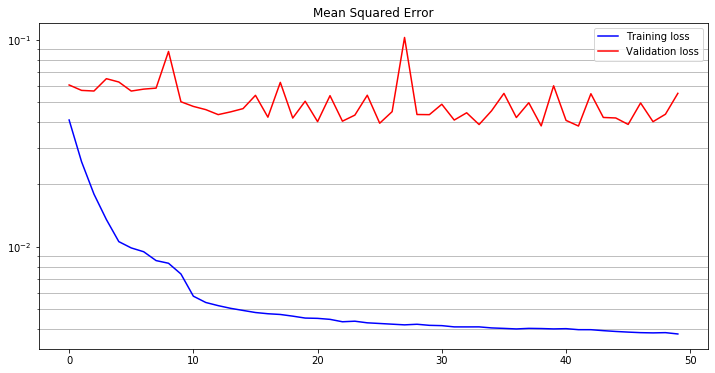

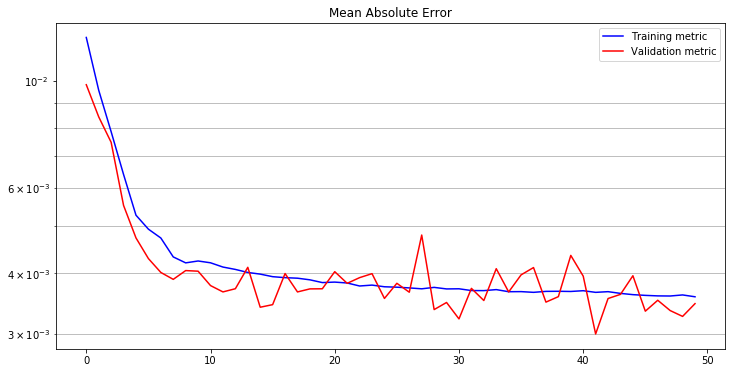

In [29]:
inputs = copy.deepcopy(normal_inputs)
inputs['teacher_forcing'] = False
epochs = 50

m = Seq2SeqModel(**inputs)
h = m.fit_custom(train_dataset=train_dataset, 
                 epochs=epochs, 
                 steps_per_epoch=steps_per_epoch, 
                 vad_dataset=vad_dataset)

plot_train_history(h, 'Mean Squared Error', 'loss')
plot_train_history(h, 'Mean Absolute Error', 'metric')